# Model Selection

In this section, we will test various models and evaluate their performance. We want to find the model that best handles our data. We will test four models: one from each of the following four categories below.

## Basic Model
* Logistic Regresssion

## Kernelized
* Support Vector Machine Classification

## Bayesian
* Gaussian Naive Bayes

## Tree-based
* XGBoost

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
from xgboost import XGBClassifier

The data has already been preprocessed from [`gym_churn_clustering.ipynb`](gym_churn_clustering.ipynb). We just need to load the data and split it using the same value for `random_state`.

In [2]:
df = pd.read_csv('data/gym_data_preprocessed.csv')
df.set_index('Member_ID', inplace=True)

X = df.drop('Churn', axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) # same seed from `gym_churn_clustering.ipynb`

print(f'X_train.shape: {X_train.shape}')
print(f'y_train.shape: {y_train.shape}')
print(f'X_test.shape: {X_test.shape}')
print(f'y_test.shape: {y_test.shape}')

X_train.shape: (3200, 16)
y_train.shape: (3200,)
X_test.shape: (800, 16)
y_test.shape: (800,)


Now we can train and test the models. We will evaluate each model using the accuracy, precision, recall, and F1 score.

`accuracy` = $\dfrac{\text{Total Correct}}{\text{Total Sample Size}}$
- incentivizes few mistakes

`precision` = $\dfrac{\text{Total Correct Positive Guesses}}{\text{Total Positive Guesses}}$
- incentivizes correctly identifying positive labels
- minimize type 1 error (false positive)

`recall` = $\dfrac{\text{Total Correct Positive Guesses}}{\text{Total Positive Labels}}$
- incentivizes model to correctly identify all positive labels
- minimize type 2 error (false negative)

`F1` = $\dfrac{2\cdot\texttt{precision}\cdot\texttt{recall}}{\texttt{precision}+\texttt{recall}}$
- incentivizes high precision and recall

In [3]:
def evaluate_model(model, X, y_true):
    y_hat = model.predict(X)
    y_score = model.predict_proba(X)[:,1]

    # compute metrics
    accuracy = accuracy_score(y_true, y_hat)
    precision = precision_score(y_true, y_hat)
    recall = recall_score(y_true, y_hat)
    f1 = f1_score(y_true, y_hat)
    roc_auc = roc_auc_score(y_true, y_score)

    print(f'{model} Scores:')
    print(f'\tAccuracy: {accuracy}')
    print(f'\tPrecision: {precision}')
    print(f'\tRecall: {recall}')
    print(f'\tF1 Score: {f1}')
    print(f'\tROC AUC: {roc_auc}')

    # store metrics
    metrics_dict = {'Accuracy': accuracy,
                  'Precision': precision,
                  'Recall': recall,
                  'F1 Score': f1,
                  'ROC AUC': roc_auc}

    return y_hat, y_score, metrics_dict


def plot_conf_mat(y_true, predictions, figsize, nrows=None, ncols=None):
    n_models = len(predictions)

    # set ncols and nrows accordingly
    if nrows==ncols==None:
        ncols = 2
        nrows = nrows = (n_models//ncols) + (n_models%ncols!=0)
    elif nrows!=None and ncols!=None:
        if nrows*ncols < n_models:
            raise ValueError("nrows*ncols less than n_models")
    elif nrows==None and ncols!=None:
        nrows = (n_models//ncols) + (n_models%ncols!=0)
    elif nrows!=None and ncols==None:
        ncols = (n_models//nrows) + (n_models%nrows!=0)

    fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=figsize)
    ax = ax.flatten()
    
    for i, model_name in enumerate(predictions.keys()):
        y_hat = predictions[model_name]
    
        conf_mat = ConfusionMatrixDisplay.from_predictions(y_true, y_hat, ax=ax[i])
        conf_mat.ax_.set_title(f'{model_name} Confusion Matrix')

    return fig, ax


def plot_roc_curve(probabilities, metrics, y, ax=None):
    
    fig_exists = False
    if ax is None:
        fig, ax = plt.subplots(1,1)
        fig_exists = True
    
    for model_name in probabilities.keys():
        y_score = probabilities[model_name]
        auc = metrics[model_name]['ROC AUC']


        #RocCurveDisplay.from_estimator(model, X, y, ax=ax)
        RocCurveDisplay.from_predictions(y, y_score, ax=ax, curve_kwargs=dict(label=f'{model_name} (AUC={auc:.2f})'))
    
    ax.plot([0,1], [0,1], linestyle='--')
    ax.set_title('ROC Curves')
    ax.grid()
    
    return (fig, ax) if fig_exists else ax

In [4]:
# initialize dictionaries for predictions, probabilities, and metrics of models
models = {'Logistic Regression': LogisticRegression(random_state=0),                       # vanilla logistic regression
          'Support Vector Machine': SVC(kernel='rbf', probability=True, random_state=0),   # svm with rbf kernel
          'Gaussian Naive Bayes': GaussianNB(),                                            # gaussian naive bayes
          'XGBoost': XGBClassifier(random_state=0)}                                        # extreme gradient boosting
predictions = {}
probabilities = {}
metrics = {}

In [5]:
for model_name, model in models.items():
    model.fit(X_train, y_train)
    predictions[model_name], probabilities[model_name], metrics[model_name] = evaluate_model(model, X_test, y_test)

LogisticRegression(random_state=0) Scores:
	Accuracy: 0.91625
	Precision: 0.8258706467661692
	Recall: 0.8383838383838383
	F1 Score: 0.8320802005012531
	ROC AUC: 0.9698563710191617
SVC(probability=True, random_state=0) Scores:
	Accuracy: 0.92625
	Precision: 0.8492462311557789
	Recall: 0.8535353535353535
	F1 Score: 0.8513853904282116
	ROC AUC: 0.9667480452364174
GaussianNB() Scores:
	Accuracy: 0.81125
	Precision: 0.5750798722044729
	Recall: 0.9090909090909091
	F1 Score: 0.7045009784735812
	ROC AUC: 0.9293684351823888
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=Non

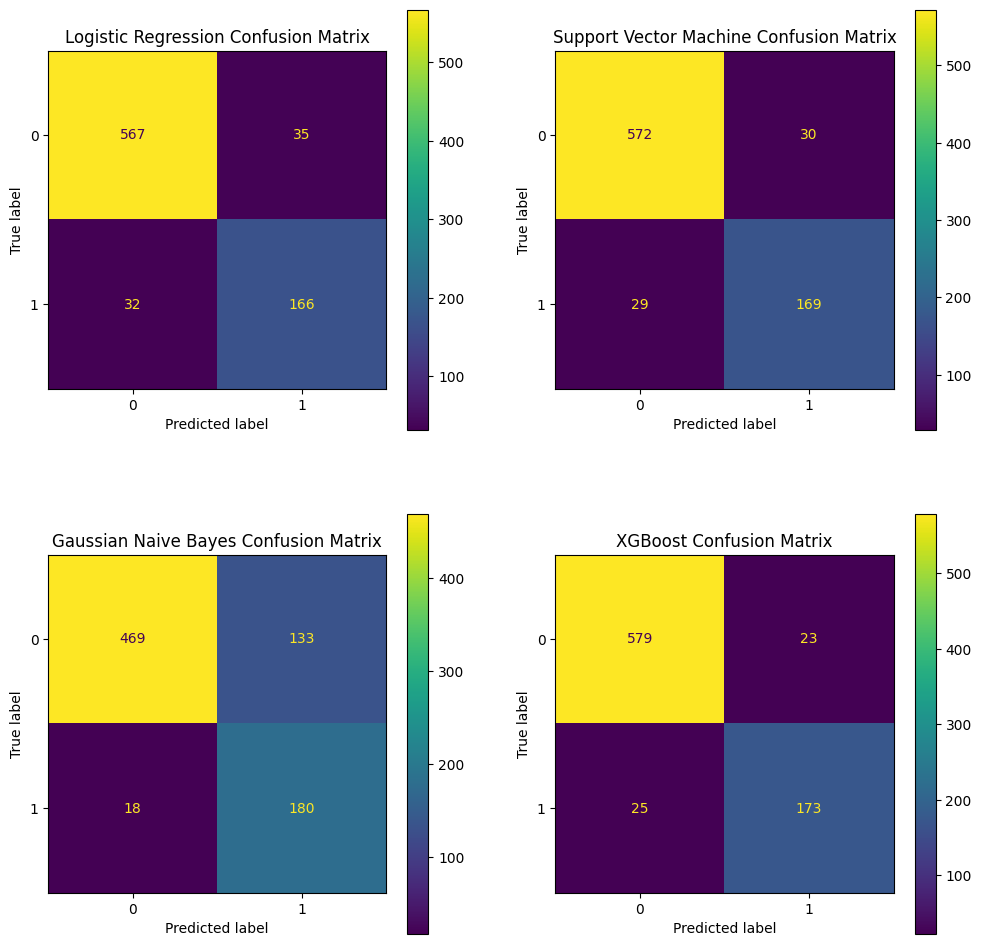

In [6]:
fig, ax = plot_conf_mat(y_test, predictions, figsize=(12,12))
plt.show()

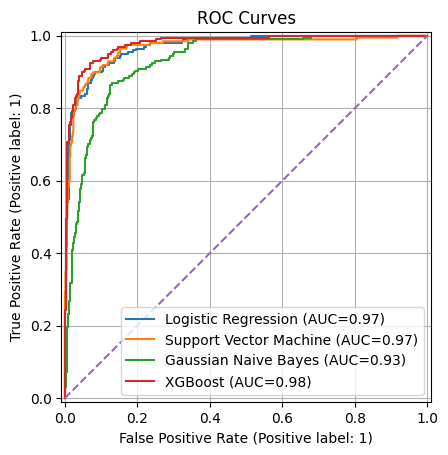

In [7]:
roc_curve = plot_roc_curve(probabilities, metrics, y_test)
plt.show()

In [8]:
# display metrics in dataframe
pd.DataFrame(metrics).T.round(2)

,Accuracy,Precision,Recall,F1 Score,ROC AUC
Logistic Regression,0.92,0.83,0.84,0.83,0.97
Support Vector Machine,0.93,0.85,0.85,0.85,0.97
Gaussian Naive Bayes,0.81,0.58,0.91,0.70,0.93
XGBoost,0.94,0.88,0.87,0.88,0.98


## Results

Each of the four models performs decently well for our data. Logistic Regression, SVM, and XGBoost all have relatively similar scores across all metrics. Gaussian Naive Bayes has higher recall, but at the expense of lower precesion and accuracy. This model could be considered more cautious in its classifications, as it makes more type 1 errors (false positives). This model is more likely to predict that a customer will leave the gym than the other three models. This leads to a large number of members incorrectly classified as leaving and a low number of members incorrectly classified as keeping their gym membership. While this model allows the gym to identify most of the customers who are going to leave the gym, it also leads to wasted efforts trying to retain members that are not going to leave.


### Logistic Regression, Support Vector Machine, XGBoost
- All three models have relatively similar scores across all metrics
- All high performing across all metrics
- XGBoost is strictly better than SVM and Logistic Regression across all metrics

### Gaussian Naive Bayes
- Highest recall at the expense of accuracy and precision
- Low type 2 (false negatives) but high type 1 (false positives)
    - Able to identify large number of customers who are going to leave
    - Leads to wasted efforts trying to retain customers who are not leaving

The results suggest that we should choose **XGBoost** as our model of choice. This model has the highest performance in terms of accuracy, precision, F1, and ROC AUC. While Gaussian Naive Bayes is able to correcctly able to identify more members that will churn, XGBoost is not far behind. Furthrmore, XGBoost makes less type 2 errors, which leads to less wasted efforts focusing on customers who are not leaving. This frees up resources for the gym which they can put towards more productive activities. 

## Feature Importance

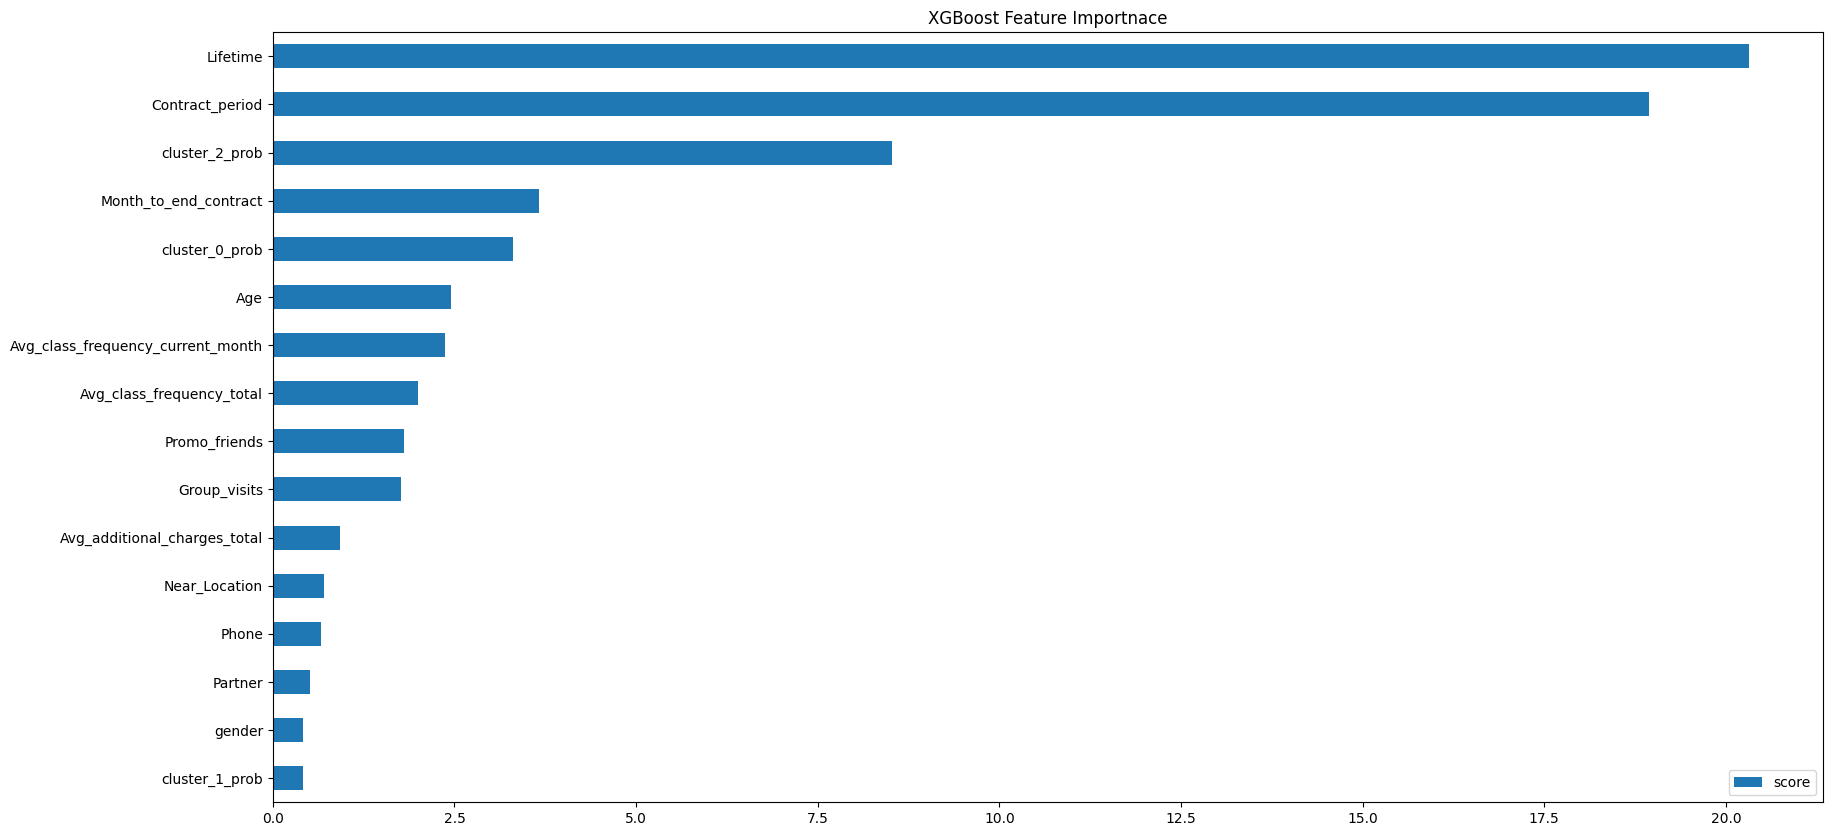

In [9]:
xgb = models['XGBoost']

feature_importance = xgb.get_booster().get_score(importance_type='gain')

keys = list(feature_importance.keys())
values = list(feature_importance.values())

feature_importance_df = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=True)
feature_importance_df.plot(kind='barh', figsize = (20,10))
plt.title('XGBoost Feature Importnace')
plt.show()

The most important features are `Lifetime`, `contract_period`, `cluster_2_prob`, `Month_to_end_contrsct`, and `cluster_0_prob`. These features have the most inflluence in determining whether or not a customer will leave the gym.

### `Lifetime`
- Gym members who have been with the gym longer are less likely to leave
    - These members have already proven to be committed to staying with the gym
- Members who have been with the gym for less time are more susceptible to leaving

### `contract_period`
- Gym members who opt for one month contracts are more likely to leave the gym
    - Shorter contract lengths gives these members flexibility on when they can leave the gym
- Gym members with longer contract lengths generally stay for longer periods as they have already made the commitment

### `cluster_2_prob`
- Members with high probability of being in cluster 2 are less likely to leave. These members were classified as the 'Gym Junkie' in [gym_churn_clustering.ipynb](gym_churn_clustering.ipynb)
- Members in this cluster likely need less attention than members in the other two clusters

### `Month_to_end_contract`
- Members in the final month of their contract are more likely to leave than members with more time left

### `cluster_0_prob`
- Members with high probability of being in cluster 0 have a high probability of leaving the gym. These members were classified as the `New Year's Resollutioners` in [gym_churn_clustering.ipynb](gym_churn_clustering.ipynb)

# Conclusion
Given the analysis, we recommend focussing efforts on members with the following characteristics:

### New members
- Keep new members engaged. These first few months are the most important for new members as this is when they are most likely to leave. 

### Short contract periods
- Members with short contract periods are less likely to stay than other members. Reminding these members to renew their contracts will help them retain their membership status. Additionally, the gym may provide incentives for longer contract periods such as lower rates for a lump sum payment upfront.

### Short time remaining on contracts
- As a member's contract expiration date approaches, they are more at risk of leaving the gym. We can keep these members from leaving by reminding them of their current benefits, and providing loyalty bonuses for staying.

### Members in cluster 0
- Members in this cluster have a higher probabilitiy of leaving the gym than members in clusters 1 and 2.
- These members tend to have shorter contract lengths (and thereby less time remaining on their contracts), so the same strategies for short contract periods and short time remaining can be applied to these members.
- These members also tend have a higher barrier to entry (no promo/partner discounts, longer commute, etc.), so keeping these members motivated to stay with the gym is important. Customers in this group could be incentivized to stay by using the following:
    - Limited time offers
    - Loyalty perks
    - More personalized experience